In [ ]:
# https://www.tensorflow.org/tutorials/audio/music_generation

# https://blog.paperspace.com/music-generation-with-lstms/

In [1]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 3.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=71270467715d82cce4ff0b8fe3e05cb4b935720bdb9b88321adff040117304f1
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
Successfully built pretty_midi


In [37]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from music21 import converter, instrument, note, chord, midi

# from IPython.display import Audio
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [4]:


from keras.layers import Dense, LSTM, LeakyReLU, Input
from keras.models import Sequential, load_model, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# saving LSTM models`
path = "/content/drive/My Drive/musegan/"


In [ ]:
# melodic midi

# rate, music1 = read('/content/drive/My Drive/Colab Notebooks/Phantasystar4ost_motavia_town_basic_pitch.mid')
# rate, music2 = read('/content/drive/My Drive/Colab Notebooks/Phantasystar4ost_motavia_village_basic_pitch.mid')




In [8]:
# training with maestro corpus
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 1s 0us/step


In [9]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [10]:
# Extracting the notes from the sample MIDI file into a DataFrame

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})



In [11]:
# # Converting to note names by considering the respective pitch values

# get_note_names = np.vectorize(pretty_midi.note_number_to_name)
# sample_note_names = get_note_names(raw_notes['pitch'])
# print(sample_note_names[:10])

# # Visualizing the paramaters of the muscial notes of the piano

def plot_piano_roll(notes: pd.DataFrame, count = None):
    print('piano roll')
    count = len(notes['pitch'])
        
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    if count:
        title = f'First {count} notes'
        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)
    else:
        title = f'Whole track'
        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)
        print(title)

In [13]:
# setup input window size
# flatten, normalize
def create_sequences(dataset: tf.data.Dataset, seq_length: int,
                     vocab_size = 128) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
    


In [ ]:
# create_train_test_split()

In [12]:
# parse midi to notes
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

Number of notes parsed: 21509


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [14]:
batch_size = 64
seq_length = 25
vocab_size = 128

seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# TODO: fix input shape

In [15]:
# Developing the model

input_shape = (seq_length, 3)
learning_rate = 0.005

xin = Input(input_shape)
x = LSTM(128)(xin)

outputs = {'pitch': Dense(128, name='pitch')(x),
           'step': Dense(1, name='step')(x),
           'duration': Dense(1, name='duration')(x),
          }

model = Model(xin, outputs)

# loss = {'pitch': SparseCategoricalCrossentropy(from_logits=True),
#         'step': mse_with_positive_pressure,
#         'duration': mse_with_positive_pressure,
#        }

optimizer = Adam(learning_rate=learning_rate)
# Compiling and fitting the model

# model.compile(loss = loss, 
#               loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration':1.0,},
#               optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [18]:
model.save(path+'midi_lstm_apr8.h5')


In [ ]:
# TODO load model 3

# TODO load model 3 weights + recreate network



In [16]:
EPOCHS = 10
BATCH_SIZE = 500

In [ ]:
# loading the saved models
model = load_model(path+'midi_lstm_apr8.h5')


In [17]:
# train
epochs = 10

history = model.fit(train_ds, 
                    epochs=epochs, 
                    batch_size=BATCH_SIZE
                    # callbacks=callbacks
                    )

Epoch 1/10
335/335 [==============================] - 23s 51ms/step - loss: 600.8502 - duration_loss: 0.1711 - pitch_loss: 600.6422 - step_loss: 0.0369 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0037 - step_accuracy: 0.0741
Epoch 2/10
335/335 [==============================] - 18s 53ms/step - loss: 158.5084 - duration_loss: 0.1455 - pitch_loss: 158.3257 - step_loss: 0.0372 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0045 - step_accuracy: 0.0741
Epoch 3/10
335/335 [==============================] - 17s 50ms/step - loss: 158.5443 - duration_loss: 0.1467 - pitch_loss: 158.3605 - step_loss: 0.0371 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0043 - step_accuracy: 0.0741
Epoch 4/10
335/335 [==============================] - 17s 50ms/step - loss: 158.5801 - duration_loss: 0.1474 - pitch_loss: 158.3956 - step_loss: 0.0371 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 0.0041 - step_accuracy: 0.0741
Epoch 5/10
335/335 [==============================] - 17s 50ms/step 

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [19]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, 
                      temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    print(predictions)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [28]:
# test file for prediction

# TODO import midi file for prediction
fp = path+'ShiningForce2_LivelyTown_basic_pitch.mid'
# fp = path+'PhantasyStar4_AirCastle_basic_pitch.mid' # user input

print(fp)
test_midi0 = pretty_midi.PrettyMIDI(fp)
print(type(test_midi0))

/content/drive/My Drive/musegan/ShiningForce2_LivelyTown_basic_pitch.mid
<class 'pretty_midi.pretty_midi.PrettyMIDI'>


In [29]:
# pm = pretty_midi.PrettyMIDI(midi_file)
pm = test_midi0
instrument = pm.instruments[0]
notes = collections.defaultdict(list)
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

# Sort the notes by start time
sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
prev_start = sorted_notes[0].start

for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

test_midi_df =  pd.DataFrame({name: np.array(value) for name, value in notes.items()})
test_midi_df.head(1)

,pitch,start,end,step,duration
0,28,0.918182,1.034091,0.0,0.115909


piano roll


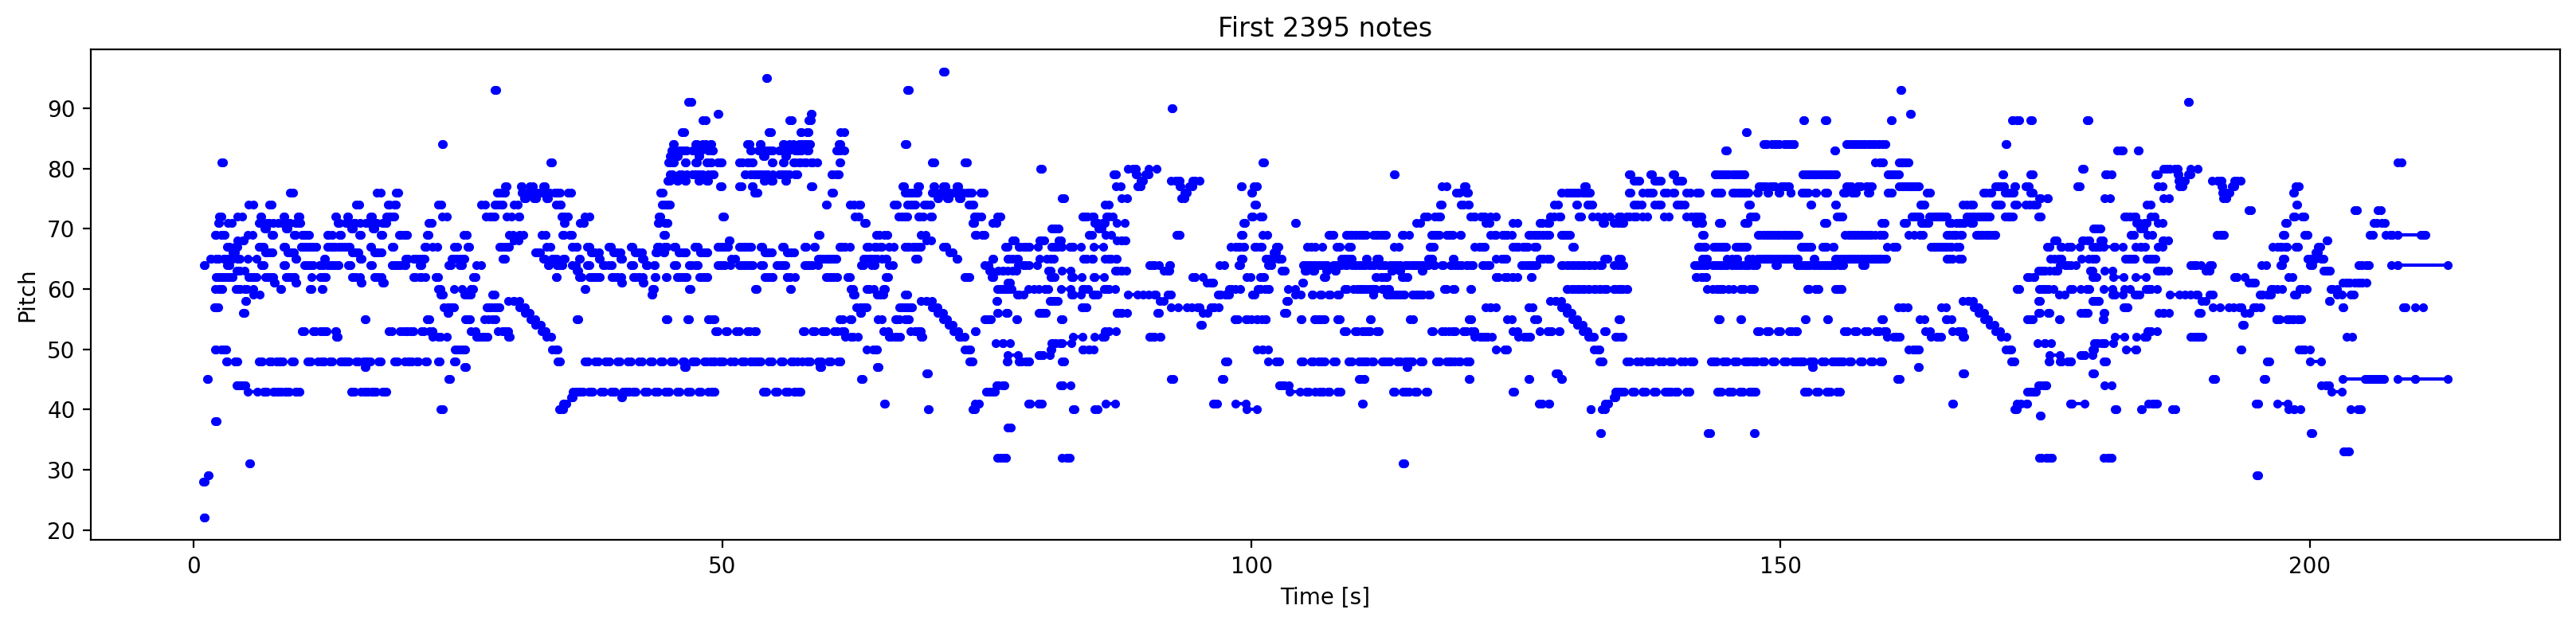

In [30]:
plot_piano_roll(test_midi_df)

In [21]:
# sample file for prediction

sample_file = filenames[1]
print(sample_file)
sample_midi = pretty_midi.PrettyMIDI(sample_file)


data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_05_R1_2015_wav--4.midi


In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
# display_audio(sample_midi)
# AttributeError: module 'fluidsynth' has no attribute 'Synth'

In [ ]:
# crate test data
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,63,0.980469,1.070312,0.000000,0.089844
1,51,0.992188,1.046875,0.011719,0.054688
2,27,0.992188,1.074219,0.000000,0.082031
3,39,1.000000,1.083333,0.007812,0.083333
4,52,2.007812,2.041667,1.007812,0.033854


piano roll


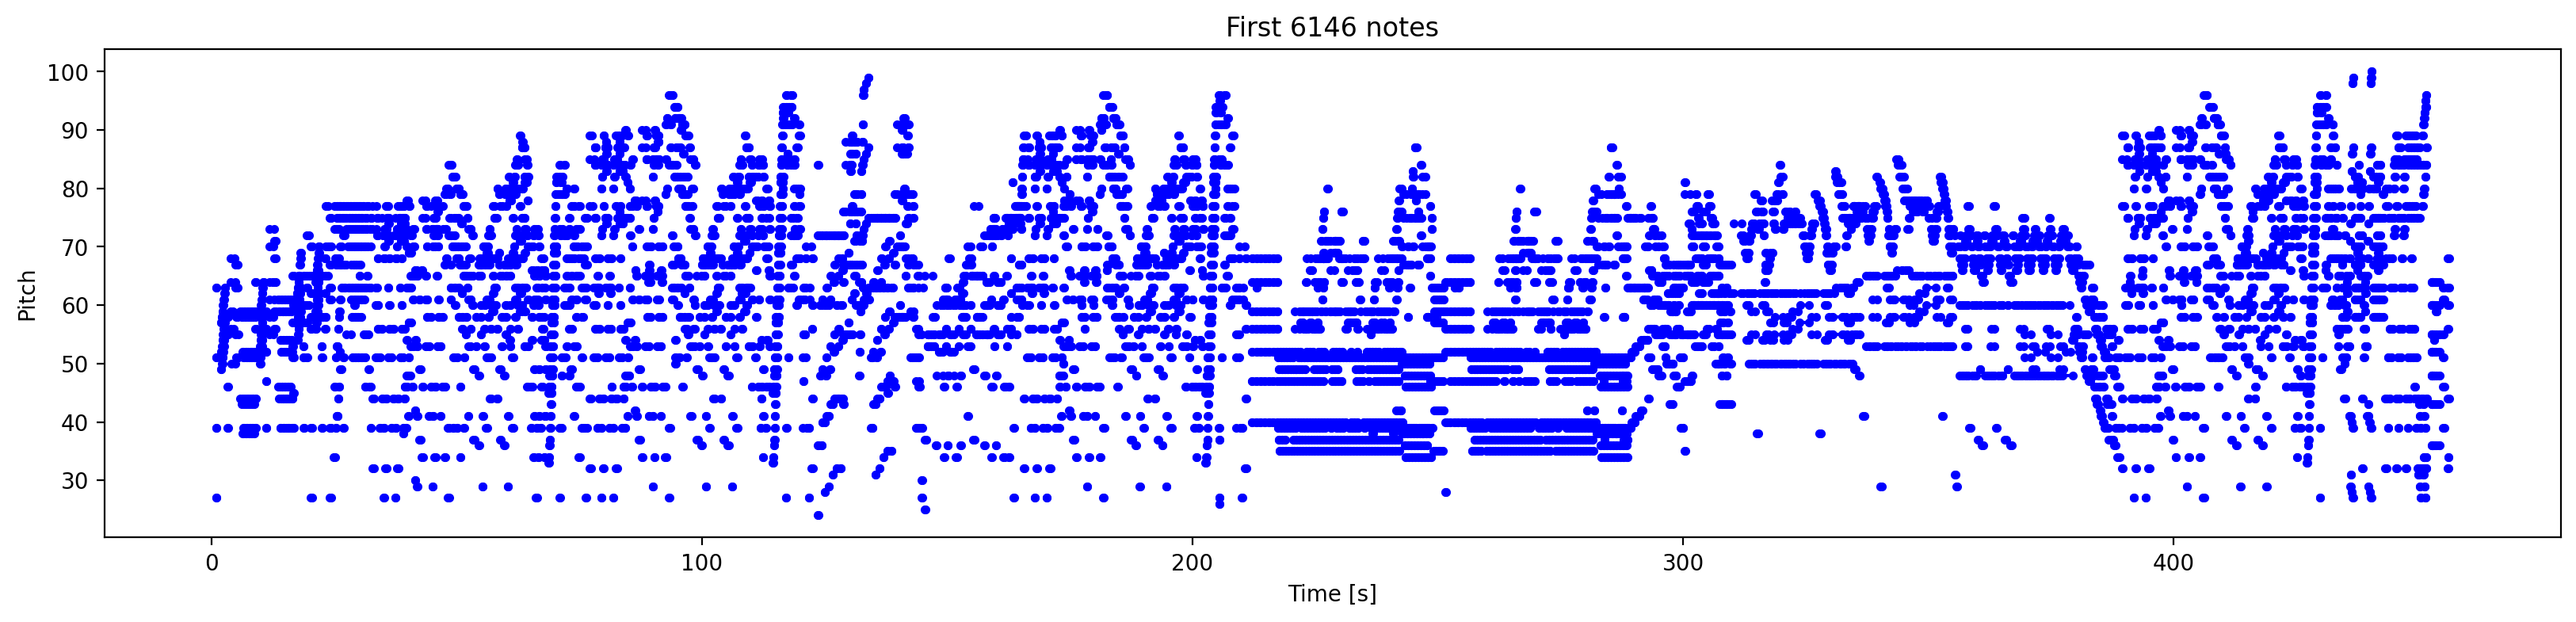

In [ ]:
plot_piano_roll(raw_notes, 100)


In [33]:
# generated notes to midi format
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

# example_file = path+'example.midi'
# example_pm = notes_to_midi(
#     raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
# pm = pretty_midi.PrettyMIDI(sample_file)
print('Number of instruments:', len(sample_midi.instruments))
instrument = sample_midi.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

# Extracting the notes
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=51, note_name=D#3, duration=0.0547
1: pitch=63, note_name=D#4, duration=0.0898
2: pitch=27, note_name=D#1, duration=0.0820
3: pitch=39, note_name=D#2, duration=0.0833
4: pitch=52, note_name=E3, duration=0.0339
5: pitch=57, note_name=A3, duration=0.0443
6: pitch=49, note_name=C#3, duration=0.0729
7: pitch=58, note_name=A#3, duration=0.0495
8: pitch=50, note_name=D3, duration=0.1029
9: pitch=53, note_name=F3, duration=0.1133


In [26]:

def generate(xin):
  # generate prediction from sample_notes
  temperature = 2.0
  num_predictions = 120
  seq_length = 25
  vocab_size = 128
  
  # sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

  # The initial sequence of notes while the pitch is normalized similar to training sequences
  input_notes = (
    xin[:seq_length] / np.array([vocab_size, 1, 1]))

  print(len(input_notes))
  generated_notes_ls = []
  prev_start = 0

  for _ in range(num_predictions):
      pitch, step, duration = predict_next_note(input_notes, model, temperature)
      start = prev_start + step
      end = start + duration
      input_note = (pitch, step, duration)
      generated_notes_ls.append((*input_note, start, end))
      input_notes = np.delete(input_notes, 0, axis=0)
      input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
      prev_start = start

  key_order = ['pitch', 'step', 'duration']
  generated_notes_df = pd.DataFrame(
      generated_notes_ls, columns=(*key_order, 'start', 'end'))

  # generated_notes_df.head(10)
  return generated_notes_df



In [31]:
key_order = ['pitch', 'step', 'duration']
sample_notes0 = np.stack([test_midi_df[key] for key in key_order], axis=1)
generated_notes0 = generate(sample_notes0)

25
1/1 [==============================] - 1s 807ms/step
{'pitch': array([[63.03832 , 63.017864, 63.03462 , 63.025837, 63.021286, 63.018517,
        63.028934, 63.03224 , 63.02583 , 63.026814, 63.017296, 63.013138,
        63.032215, 63.016964, 63.019886, 63.039276, 63.048428, 63.031998,
        63.019997, 63.040596, 63.024155, 63.031178, 63.019505, 63.024357,
        63.04228 , 63.021584, 63.042637, 63.045326, 63.020836, 63.021202,
        63.03388 , 63.036995, 63.031963, 63.018143, 63.02892 , 63.03842 ,
        63.042732, 63.02814 , 63.023716, 63.043774, 63.054882, 63.040443,
        63.04181 , 63.024063, 63.0286  , 63.03386 , 63.04395 , 63.04391 ,
        63.022343, 63.03147 , 63.02594 , 63.033966, 63.03637 , 63.02954 ,
        63.039318, 63.032154, 63.01736 , 63.037857, 63.04244 , 63.037567,
        63.034058, 63.032906, 63.035637, 63.038483, 63.020794, 63.019318,
        63.034573, 63.02745 , 63.03434 , 63.02446 , 63.03582 , 63.037895,
        63.03023 , 63.02191 , 63.010647, 63.03

In [35]:
# save generated file
out_file = path+'lstm_output_apr8.midi'
out_pm = notes_to_midi(
    generated_notes0, out_file=out_file, instrument_name=instrument_name)

In [38]:
# play output midi
# lstm_output_apr4.midi
mf0 = midi.MidiFile()
mf0.open(out_file) # path='abc.midi'
mf0.read()
mf0.close()
s0 = midi.translate.midiFileToStream(mf0)
s0.show('midi')

In [ ]:
from music21 import midi

# fp = path+'lstm_output_apr4.midi' # generated
# fp = sample_file #from corpus
fp = path+'PhantasyStar4_AirCastle_basic_pitch.mid' # user input
mf = midi.MidiFile()
mf.open(fp) # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

In [ ]:
# model evaluation

In [ ]:
# check training vs test accuracy

In [ ]:
print(history.history)

{'loss': [168.52862548828125, 168.55722045898438, 168.58631896972656, 168.6138916015625, 168.63815307617188, 168.65765380859375, 168.68325805664062, 168.67982482910156, 168.70034790039062, 168.69471740722656], 'duration_loss': [0.14269918203353882, 0.14270026981830597, 0.1427007019519806, 0.1427009403705597, 0.14270058274269104, 0.1426640897989273, 0.14255762100219727, 0.14267171919345856, 0.14266705513000488, 0.14243793487548828], 'pitch_loss': [168.3490447998047, 168.37771606445312, 168.4068145751953, 168.4344482421875, 168.45863342285156, 168.47813415527344, 168.5036163330078, 168.49990844726562, 168.52084350585938, 168.5155029296875], 'step_loss': [0.03683516010642052, 0.03683524578809738, 0.0368352010846138, 0.036835137754678726, 0.03683451563119888, 0.036829546093940735, 0.037104152143001556, 0.03727316856384277, 0.03685915842652321, 0.036753494292497635], 'duration_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'pitch_accuracy': [9.469696669839323e-05, 0.0, 9.469

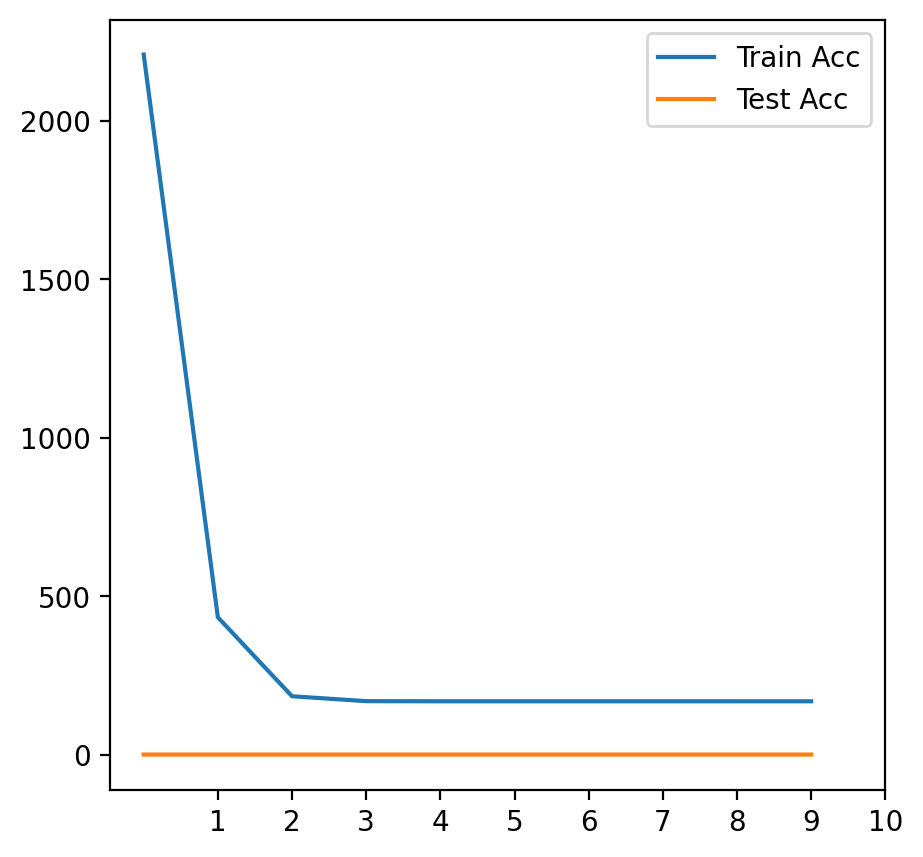

In [ ]:
import matplotlib.pyplot as plt
train_acc = history.history['pitch_accuracy']
train_loss = history.history['pitch_loss']

# test_loss = history.history['loss']

plt.figure(figsize=(5,5))

plt.plot(train_loss,label='Train Acc')
plt.plot(train_acc,label='Test Acc')

plt.xticks(range(1,11),range(1,11))
plt.legend()



([<matplotlib.axis.XTick at 0x7f11dd616a90>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

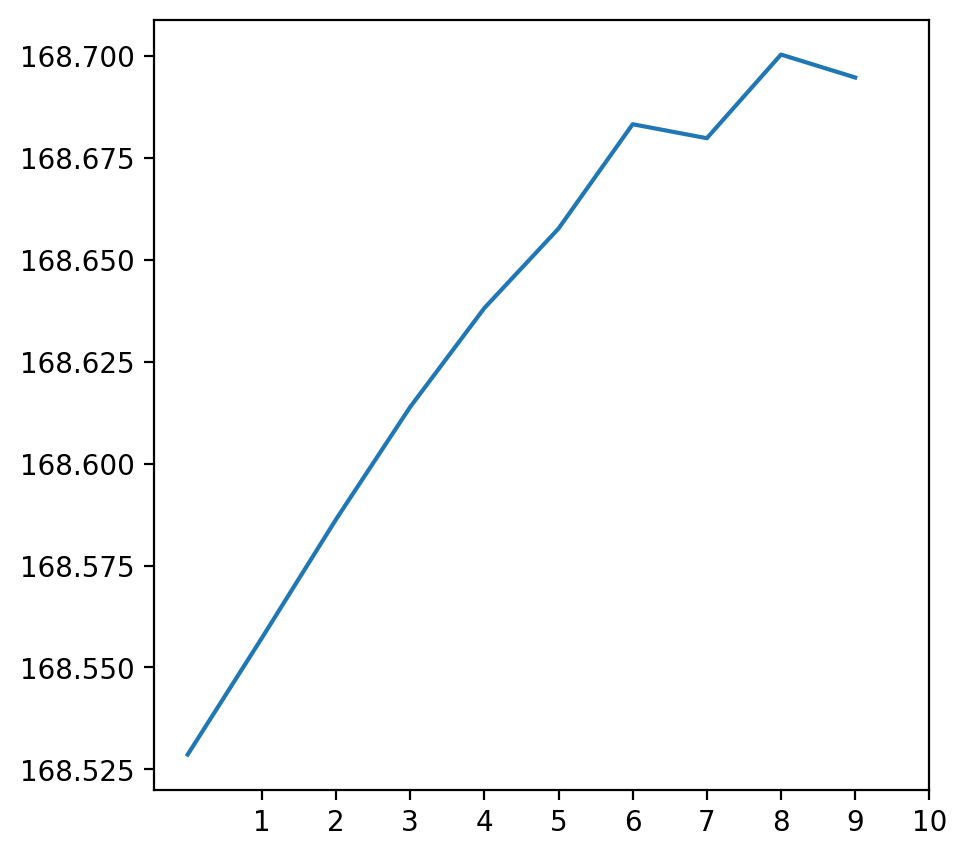

In [ ]:
import matplotlib.pyplot as plt
# train_acc = history.history['pitch_accuracy']
# train_loss = history.history['pitch_loss']

test_loss = history.history['loss']

plt.figure(figsize=(5,5))

# plt.plot(train_loss,label='Train Acc')
plt.plot(test_loss,label='Test Loss')

plt.xticks(range(1,11),range(1,11))




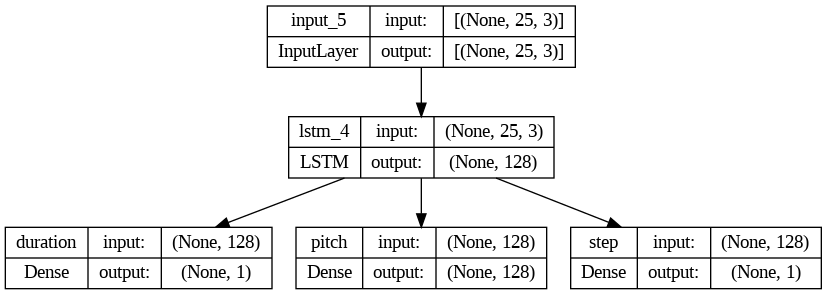

In [ ]:
# https://keras.io/api/utils/model_plotting_utils/

from tensorflow.keras import utils

utils.plot_model(model, to_file=path+'lstm_diagram2.png', show_shapes=True)
